# Examine Measurements

This notebook is for examining the dose-response measurements for the compounds selected from the direct-to-biology assay, as well as those selected from the enumerated library.

Load experimental measurements

In [1]:
import pandas as pd

df_cdd = pd.read_excel(
    '../data/raw/prospective_measurements.xlsx')
df_cdd['IC50'] = df_cdd['Protease_SARS_Cov2_Mpro_fluorescence_dose_response: IC50 (µM)'].astype(str).str.replace(
    '< ', '')
df_cdd['IC50'] = df_cdd['IC50'].astype(str).str.replace(
    '> ', '')
df_cdd['IC50'] = df_cdd['IC50'].astype(float)
df_cdd['SMILES'] = df_cdd["CXSMILES (CDD Compatible)"].str.replace(
    ' .*', '')
df_cdd.loc[0, 'SMILES']


'FC(F)(F)C1=CN=C(NC(=O)CN2C[C@H](C(=O)NC3=C4C=CC=CC4=CN=C3)C3=C(C2)C=CC(Cl)=C3)C=C1 |&1:14,c:18,20,22,25,27,30,34,37,40,t:4,6|'

Load our predictions

In [2]:
df_top20 = pd.read_csv('../data/predictions/top_20.csv')
df_false_negatives = pd.read_csv('../data/predictions/false_negatives.csv')
df_false_negatives['Average Prediction (%)'] = df_false_negatives[['RF Predicted Inhibition (%)', 'GP Predicted Inhibition (%)']].mean(axis=1)
df_best_amides = pd.read_csv('../data/predictions/best_amides.csv')
df_best_amides['Average Prediction (%)'] = df_best_amides[[
    'Random Forest', 'Gaussian Process']].mean(axis=1)
df_best_amides['SMILES'] = df_best_amides['amide']

df_false_negatives


Use morgan fingerprint similarity to connect model predictions to assay measurements

In [5]:
import useful_rdkit_utils

def gen_fps(df_in):
    useful_rdkit_utils.add_molecule_and_errors(
        df_in, smiles_col='SMILES', mol_col_name='mol', error_col_name='Error')

    df_in['fps'] = [useful_rdkit_utils.mol2morgan_fp(mol) for mol in df_in['mol'].values]
    return df_in

for df in [df_top20, df_false_negatives, df_best_amides, df_cdd]:
    gen_fps(df)

In [6]:
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles, AllChem
from tqdm import tqdm

import numpy as np

df_top20['Data'] = 'Top 20 Crude Compounds'
df_false_negatives['Data'] = 'False Negative'
df_best_amides['Data'] = 'in-silico Predicted Amides'
df_submitted = pd.concat([df_top20, df_false_negatives, df_best_amides]).reset_index(drop=True)
sim_mat = np.empty((len(df_cdd), len(df_submitted)))
for i in tqdm(range(len(df_cdd['fps']))):
    sim_mat[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(df_cdd.loc[i, 'fps'], df_submitted['fps'].values))

    similarity = sim_mat[i]
    # print(similarity)
    if np.max(similarity) > 0.8:
        j = np.argmax(similarity)
        data_source = df_submitted.loc[j, 'Data']
        if data_source == 'Enamine Amide':
            print(
                f"ID={df_cdd.loc[i, 'Molecule Name']},IC50={df_cdd.loc[i, 'IC50']:.3f}uM from {data_source}, Predicted inhibition = (GP = {df_submitted.loc[j, 'Gaussian Process']:.1f}% , RF = {df_submitted.loc[j, 'Random Forest']:.1f}%)")
        else:
            print(f"ID={df_cdd.loc[i, 'Molecule Name']},IC50={df_cdd.loc[i, 'IC50']:.3f}uM from {data_source}, Predicted inhibition = (Average = {df_submitted.loc[j, 'Average Prediction (%)']:.1f}%)")

        df_cdd.loc[i, 'Data'] = df_submitted.loc[j, 'Data']


ID=ASAP-0000362,IC50=0.407uM from Top 20 Crude Compounds, Predicted inhibition = (Average = 20.2%)
ID=ASAP-0000256,IC50=99.500uM from False Negative, Predicted inhibition = (Average = 53.8%)
ID=ASAP-0000227,IC50=0.076uM from in-silico Predicted Amides, Predicted inhibition = (Average = 87.9%)
ID=ASAP-0000227,IC50=0.077uM from in-silico Predicted Amides, Predicted inhibition = (Average = 87.9%)
ID=ASAP-0000226,IC50=0.037uM from in-silico Predicted Amides, Predicted inhibition = (Average = 71.6%)
ID=ASAP-0000226,IC50=0.046uM from in-silico Predicted Amides, Predicted inhibition = (Average = 71.6%)
ID=ASAP-0000226,IC50=0.056uM from in-silico Predicted Amides, Predicted inhibition = (Average = 71.6%)
ID=ASAP-0000226,IC50=1.168uM from in-silico Predicted Amides, Predicted inhibition = (Average = 71.6%)
ID=ASAP-0000226,IC50=0.057uM from in-silico Predicted Amides, Predicted inhibition = (Average = 71.6%)
ID=ASAP-0000225,IC50=0.070uM from Top 20 Crude Compounds, Predicted inhibition = (Averag

Take mean of IC50s across multiple dose-response measurements

In [7]:
df_ic50 = df_cdd[['Molecule Name', 'IC50']].groupby('Molecule Name').mean()*1000
df_ic50['SMILES'] = df_cdd[['Molecule Name', 'SMILES', 'IC50']].groupby('Molecule Name')['SMILES'].first()
df_ic50['Data'] = df_cdd[['Molecule Name', 'Data', 'IC50']].groupby('Molecule Name')['Data'].first()

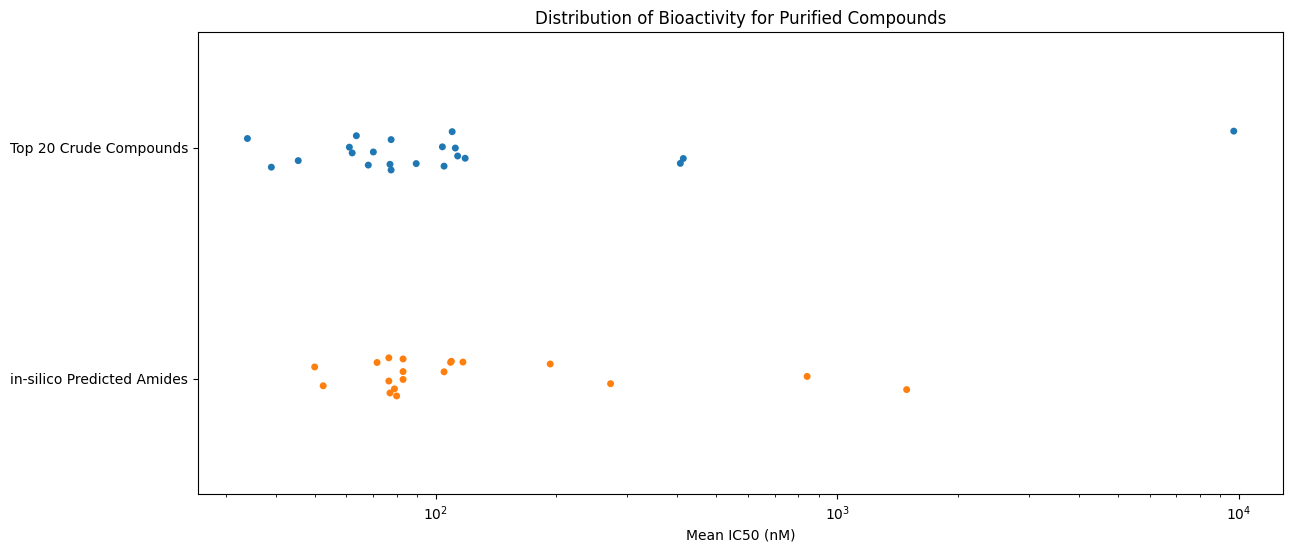

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtering out 'False Negative'
df_filtered = df_ic50.query('Data != "False Negative"')

# Creating the scatter plot
plt.figure(figsize=(14, 6))  # Set the figure size
sns.stripplot(data=df_filtered, x='IC50', y='Data', hue='Data')

# # Customizing the plot
plt.xscale('log')  # Setting log scale for the x-axis
plt.xlabel('Mean IC50 (nM)')  # Setting x-axis label
plt.ylabel('')  # Setting y-axis label to empty
plt.title('Distribution of Bioactivity for Purified Compounds')  # Setting title

plt.show()  # Display the plot
